In [1]:
from cvxopt import matrix, solvers
import numpy as np
import scipy
from scipy.special import comb
from itertools import combinations
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from matplotlib import pyplot as plt

solvers.options['show_progress'] = False
rng = np.random.RandomState(8)

In [2]:
N = 12
M = 6
S = 5
T = 100
r_max = 30
l = 4
reward_constant = 10
sensor_constant = 2
cost_constant = 0.005
risk_constant = 0.005
cost_risk_constant = 0.05

print('number of attacker strategies: ', comb(S, l, exact=True)*r_max)

p_mins_list = np.arange(0.2, M/2, 0.2)
print('p_mins list: ', p_mins_list)

number of attacker strategies:  150
p_mins list:  [0.2 0.4 0.6 0.8 1.  1.2 1.4 1.6 1.8 2.  2.2 2.4 2.6 2.8]


In [3]:
def s(a):
    return np.sqrt(a)

dist_T_R = [[0, 0, 10, 20, 0, 0, 10, 20, 10, 10, 20, 20],
            [10, 0, 0, 10, 10, 0, 0, 10, s(2)*10, 10, s(5)*10, 20],
            [s(5)*10, s(2)*10, 10 ,10, 20, 10, 0, 0, 20, 10, s(5), s(2)*10],
            [s(2)*10, 10, 10, s(2)*10, 10, 0, 0, 10, 10, 0, s(2)*10, 10],
            [10, s(2)*10, s(5)*10, s(10)*10, 0, 10, 20, 30, 0, 10, 10, s(2)*10], 
            [s(5)*10, 20, 20, s(8)*10, s(2)*10, 10, 10, s(2)*10, 10, 0, 10, 0]]
dist_T_R = np.array(dist_T_R)

dist_T_S = [[10, 30, 10, s(2)*10, s(10)*10],
           [s(2)*10, 10, 20, 10, s(13)*10],
           [s(2)*10, 10, 30, 0, s(8)*10],
           [s(5)*10, s(5)*10, 20, 0, s(2)*2],
           [20, s(17)*10, 0, 10, 20],
           [s(10)*10, s(8)*10, s(5)*10, 0, s(5)*10]]
dist_T_S = np.array(dist_T_S)

walls_T_R = [[0, 1, 2, 3, 1, 1, 2, 3, 2, 2, 3, 3],
            [2, 1, 0, 1, 2, 1, 1, 2, 3, 3, 4, 4],
            [4, 3, 2, 1, 3, 2, 1, 0, 4, 3, 5, 4],
            [1, 1, 2, 3, 1, 0, 1, 2, 2, 1, 3, 2],
            [2, 3, 4, 5, 1, 2, 3, 4, 0, 1, 1, 1],
            [3, 3, 3, 4, 2, 2, 2, 3, 2, 1, 1, 0]]
walls_T_R = np.array(walls_T_R)

walls_T_S = [[1, 4, 2, 3, 4],
            [3, 2, 3, 1, 4],
            [5, 2, 4, 2, 5],
            [2, 3, 2, 1, 3],
            [3, 5, 2, 2, 2],
            [4, 5, 4, 2, 1]]
walls_T_S = np.array(walls_T_S)

# directions 
dr = np.zeros((M, S, N))

dr[0,0,0] = 1
dr[0,1,1], dr[0,1,2], dr[0,1,3] = 1, 1, 1
dr[0,2,4] = 1
dr[0,3,5], dr[0,3,6] = 1, 1
dr[0,4,4], dr[0,4,8], dr[0,4,10] = 1, 1, 1

dr[1,0,0], dr[1,0,1] = 1, 1
dr[1,1,2], dr[1,1, 3] = 1, 1
dr[1,2,4], dr[1,2,5] = 1, 1
dr[1,3,6] = 1
dr[1,4,5], dr[1,4,8], dr[1,4,9], dr[1,4,10] = 1, 1, 1, 1

dr[2,0,0], dr[2,0,1], dr[2,0,6] = 1, 1, 1
dr[2,1,3], dr[2,1,7] = 1, 1
dr[2,2,4], dr[2,2,5], dr[2,2,6] = 1, 1, 1
dr[2,4,9], dr[2,4,10], dr[2,4,11] = 1, 1, 1

dr[3,0,0], dr[3,0,1] = 1, 1
dr[3,1,2], dr[3,1,3], dr[3,1,6], dr[3,1,7] = 1, 1, 1, 1
dr[3,2,4], dr[3,2,5] = 1, 1
dr[3,4,8], dr[3,4,9], dr[3,4,10] = 1, 1, 1

dr[4,0,0], dr[4,0,4] = 1, 1
dr[4,1,3], dr[4,1,5], dr[4,1,6] = 1, 1, 1
dr[4,3,9] = 1
dr[4,4,8], dr[4,4,10] = 1, 1

dr[5,0,0], dr[5,0,1], dr[5,0,4], dr[5,0,5], dr[5,0,9] = 1, 1, 1, 1, 1
dr[5,1,3], dr[5,1,6], dr[5,1,7] = 1, 1, 1
dr[5,2,4], dr[5,2,8], dr[5,2,9] = 1, 1, 1
dr[5,4,10], dr[5,4,11] = 1, 1

dr = np.swapaxes(dr, 1, 2)
print(dr.shape)

# mm frequency
def mm_rss(d,w):
    if d==0:
        d=1
    return -51 - 20 * np.log10(d) - w*6

def compute_T_rss(dist_T, walls):
    a, b = dist_T.shape[0], dist_T.shape[1]
    res = np.zeros((a, b))
    for i in range(a):
        for j in range(b):
            res[i,j] = mm_rss(dist_T[i,j], walls[i,j])
    return res

TR_rss = compute_T_rss(dist_T_R, walls_T_R)
TS_rss = compute_T_rss(dist_T_S, walls_T_S)

tot_rss = np.zeros((M, N, S))
for a in range(M):
    for b in range(N):
        for c in range(S):
            tot_rss[a,b,c] = TS_rss[a,c]

# tot_rss = np.multiply(tot_rss, dr)
max_tot_rss = np.max(tot_rss)
rel_tot_rss = tot_rss - max_tot_rss
rel_tot_rss = rel_tot_rss/10
CF = np.power(10, rel_tot_rss)
CF = np.multiply(CF, dr)

(6, 12, 5)


In [4]:
r_max_s = rng.randint(1, r_max+1, S)
RS = np.ones((r_max, S))
risk_ratios = rng.rand(r_max, S)
costs = np.zeros((r_max, S))
risks = np.zeros((r_max, S))
for r in range(r_max):
    for s in range(S):
        RS[r, s] = sensor_constant*np.minimum((r+1)/r_max_s[s], 1)
        costs[r, s] = cost_constant*(r+1)
        risks[r, s] = risk_constant*(risk_ratios[r, s])
        
AD = np.zeros((M, N, r_max, S))
for m in range(M):
    for n in range(N):
        for r in range(r_max):
            for s in range(S):
                AD[m, n, r, s] = CF[m, n, s]*RS[r, s]

PM = rng.rand(N, T)*reward_constant

# neighbors
nbr = [[1, 1, 0, 1, 1, 0],
      [1, 1, 0, 1, 0, 0],
      [1, 1, 1, 1, 0, 0],
      [0, 1, 1, 1, 0, 0],
      [1, 1, 0, 1, 1, 0],
      [1, 1, 1, 1, 1, 1],
      [1, 1, 1, 1, 0, 0],
      [0, 1, 1, 1, 0, 0],
      [1, 0, 0, 1, 1, 1],
      [1, 0, 1, 1, 1, 1],
      [0, 0, 0, 1, 1, 1],
      [0, 0, 0, 1, 1, 1]]

nbr = np.array(nbr)

In [5]:
# create constraint matrices per time slot

# regular constraints
G = []
h = []
# c_j,t < 1
for i in range(1, M+1, 1):
    g = np.zeros(M+1)
    g[i] = 1
    G += [g]
    h += [1]
# c_j,t > 0
for i in range(1, M+1, 1):
    g = np.zeros(M+1)
    g[i] = -1
    G += [g]
    h += [0]

G = np.array(G).astype(float)
h = np.array(h).astype(float)

# for individual time slots
full_nbr = np.hstack((np.zeros(N).reshape(N, 1), nbr)).astype(float)

# p_mins = np.ones(N)*p_min
# G = np.vstack((G, full_nbr))
# h = np.concatenate((h, p_mins))

c = np.zeros(M+1).astype(float)
c[0] = 1

print(G.shape, h.shape, c.shape)

(12, 7) (12,) (7,)


In [6]:
opts = np.zeros((len(p_mins_list), T))
for t in range(T):
    for p, p_min in enumerate(p_mins_list):
        # utility constraints
        A = []
        b = []
        comb = combinations(list(np.arange(S, dtype=int)), l)
        for cm in list(comb):
            for r in range(r_max):
                list_c = list(cm)
    #             temp = np.multiply(np.sum(PD[:, r, list_c], axis=1), Re_a[:, t])
                temp = np.dot(np.sum(AD[:, :, r, list_c], axis=2), PM[:, t])
                if (np.sum(costs[r, list_c]) + np.sum(risks[r, list_c]))/l <= cost_risk_constant:
#                     print((np.sum(costs[r, list_c]) + np.sum(risks[r, list_c]))/l)
                    A += [temp]
                    b += [np.sum(temp)]
        A = np.array(A)
        b = np.array(b)
        A = np.hstack((np.ones(A.shape[0]).reshape((A.shape[0], 1)), A)).astype(float)
        
        p_mins = np.ones(N)*p_min
        p_mins = np.sum(full_nbr, axis=1) - p_mins
        G_ = np.vstack((G, full_nbr))
        h_ = np.concatenate((h, p_mins))

        # combine constraints 
        A = np.vstack((G_, -1*A))
        b = np.concatenate((h_, -1*b))

        A_ = matrix(A)
        b_ = matrix(b)
        c_ = matrix(c)

        sol = solvers.lp(c_, A_, b_, solver='glpk')
    #     sol = solvers.lp(c_, A_, b_)

        solution = np.array(list(sol['x']))
        status = sol['status']
        opts[p, t] = solution[0]
    if t%10 == 0:
        print('done t = ', t)

done t =  0
done t =  10
done t =  20
done t =  30
done t =  40
done t =  50
done t =  60
done t =  70
done t =  80
done t =  90


In [7]:
means = np.mean(opts, axis=1)
stds = np.std(opts, axis=1)

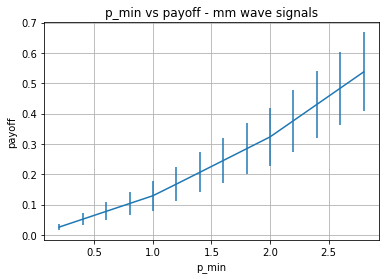

In [8]:
plt.errorbar(p_mins_list, means, stds,)
plt.grid(which='both')
plt.title('p_min vs payoff - mm wave signals')
plt.xlabel('p_min')
plt.ylabel('payoff')
plt.show()

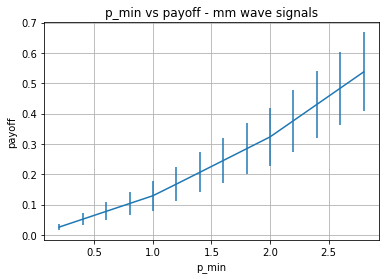

In [9]:
plt.errorbar(p_mins_list, means, stds,)
plt.grid(which='both')
plt.title('p_min vs payoff - mm wave signals')
plt.xlabel('p_min')
plt.ylabel('payoff')
plt.savefig('mm_p_min.pdf')